In [ ]:
pip install keras-tcn

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and preprocess data
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values

# Split dataset into train, validation, and test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Reshape for TCN input: (samples, timesteps, features)
X_train_tcn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_tcn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_tcn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"TCN Input Shapes - Train: {X_train_tcn.shape}, Validation: {X_val_tcn.shape}, Test: {X_test_tcn.shape}")

TCN Input Shapes - Train: (1379, 1, 6), Validation: (394, 1, 6), Test: (198, 1, 6)


In [ ]:
input_shape=(1,6)

In [ ]:
from tensorflow.keras.optimizers import Adam


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test).flatten()

    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    epsilon = 1e-8
    mape = np.mean(np.abs((y_test - predictions) / (y_test + epsilon))) * 100

    print(f"\n{model_name} Performance Metrics:")
    print("=" * 40)
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"RMSE (Root Mean Square Error):     {rmse:.4f}")
    print(f"MAE (Mean Absolute Error):         {mae:.4f}")
    print(f"MAPE (Mean Absolute % Error):      {mape:.2f}%")
    print("=" * 40)

    return {
        'predictions': predictions,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }


In [ ]:
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    # Plot 2: Residuals
    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    # Plot 3: Distribution of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    # Plot 4: Time series comparison
    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## **TCN–LSTM Hybrid with Attention (No Convolutional Layers)**


Fold 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Fold 1 R²: 0.9630, RMSE: 24.2450, MAE: 20.6434, MAPE: 8.97%

Fold 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Fold 2 R²: 0.9662, RMSE: 22.9539, MAE: 17.5902, MAPE: 8.26%

Fold 3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Fold 3 R²: 0.9316, RMSE: 32.5345, MAE: 22.5715, MAPE: 7.52%

Fold 4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Fold 4 R²: 0.8956, RMSE: 40.5784, MAE: 35.4980, MAPE: 11.11%

Fold 5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Fold 5 R²: 0.9397, RMSE: 30.6151, MAE: 27.3234, MAPE: 9.99%

Final Cross-Validated Metrics:
Mean R²:    0.9392
Mean RMSE:  30.1854
Mean MAE:   24.7253
Mean MAPE:  9.17%


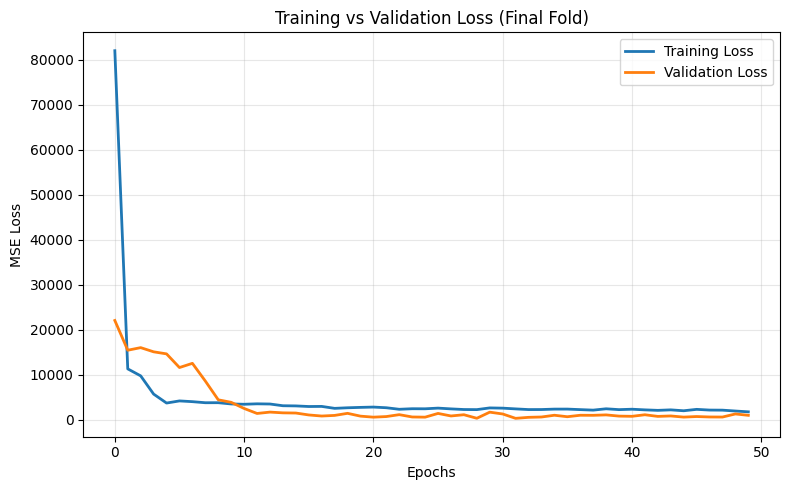

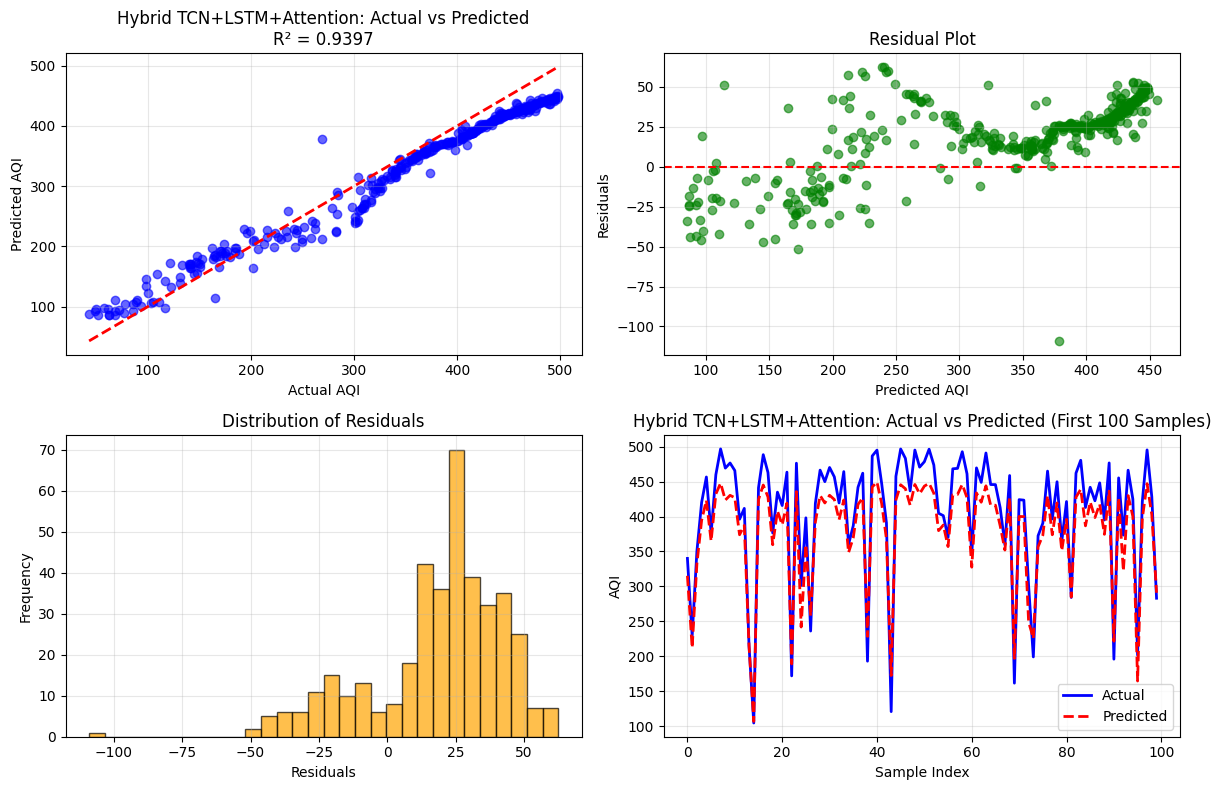

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Concatenate, LeakyReLU, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# Load and preprocess data
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Attention block
def attention_block(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax')(inputs)
    return Multiply()([inputs, attention_weights])

# Hybrid model
def create_hybrid_model_no_conv_with_attention(input_shape, tcn_filters=64, lstm_units=128):
    inputs = Input(shape=input_shape)

    tcn_branch = TCN(
        nb_filters=tcn_filters,
        kernel_size=2,
        dilations=[1, 2],
        activation='relu',
        dropout_rate=0.1,
        padding='causal',
        return_sequences=False,
        name='tcn_branch'
    )(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    lstm_branch = LSTM(lstm_units, activation='relu', return_sequences=False, name='lstm_branch')(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    combined = Concatenate()([tcn_branch, lstm_branch])
    attended = attention_block(combined)

    x = Dense(64)(attended)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32)(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

# Plot function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

# For plotting
final_y_val, final_preds, final_history = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_hybrid_model_no_conv_with_attention(input_shape=(1, 6))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    print(f"Fold {fold + 1} R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    # Save last fold for plotting
    if fold == kf.get_n_splits() - 1:
        final_y_val = y_val
        final_preds = preds
        final_history = history

# Final CV Metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot prediction results
plot_model_results(final_y_val, final_preds, model_name="Hybrid TCN+LSTM+Attention")


## **TCN–LSTM Hybrid Model (No Attention, No Convolutional Layer)**

In [ ]:
def create_hybrid_model_no_conv(input_shape, tcn_filters=64, lstm_units=128):
    inputs = Input(shape=input_shape)

    # TCN Branch
    tcn_branch = TCN(
        nb_filters=tcn_filters,
        kernel_size=2,
        dilations=[1, 2],
        activation='relu',
        dropout_rate=0.1,
        padding='causal',
        return_sequences=False,
        name='tcn_branch'
    )(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    # LSTM Branch
    lstm_branch = LSTM(lstm_units, activation='relu', return_sequences=False, name='lstm_branch')(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    # Combine TCN and LSTM branches
    combined = Concatenate()([tcn_branch, lstm_branch])

    x = Dense(64)(combined)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)

    return Model(inputs=inputs, outputs=outputs)



Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
R²: 0.9775, RMSE: 18.8986, MAE: 15.8942, MAPE: 5.44%

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
R²: 0.9849, RMSE: 15.3462, MAE: 9.5691, MAPE: 4.07%

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
R²: 0.9539, RMSE: 26.7129, MAE: 11.9689, MAPE: 6.12%

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
R²: 0.9760, RMSE: 19.4355, MAE: 16.0851, MAPE: 6.47%

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
R²: 0.9544, RMSE: 26.6252, MAE: 22.7323, MAPE: 8.78%

Final Cross-Validated Metrics:
Mean R²:    0.9694
Mean RMSE:  21.4037
Mean MAE:   15.2499
Mean MAPE:  6.17%


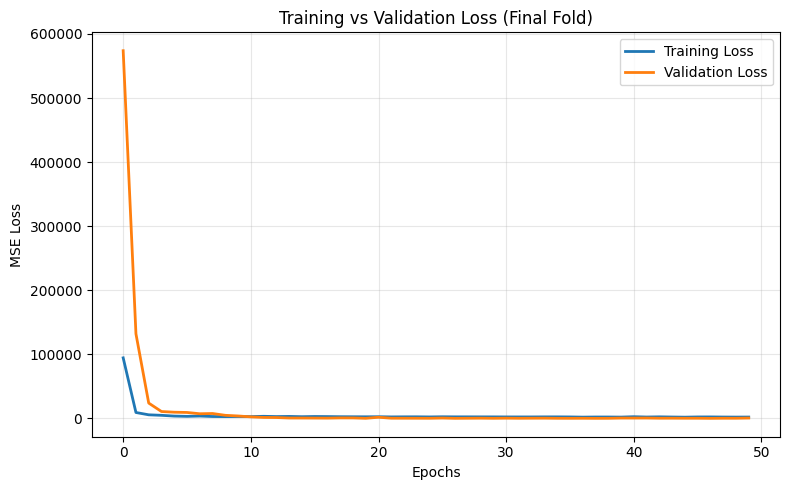

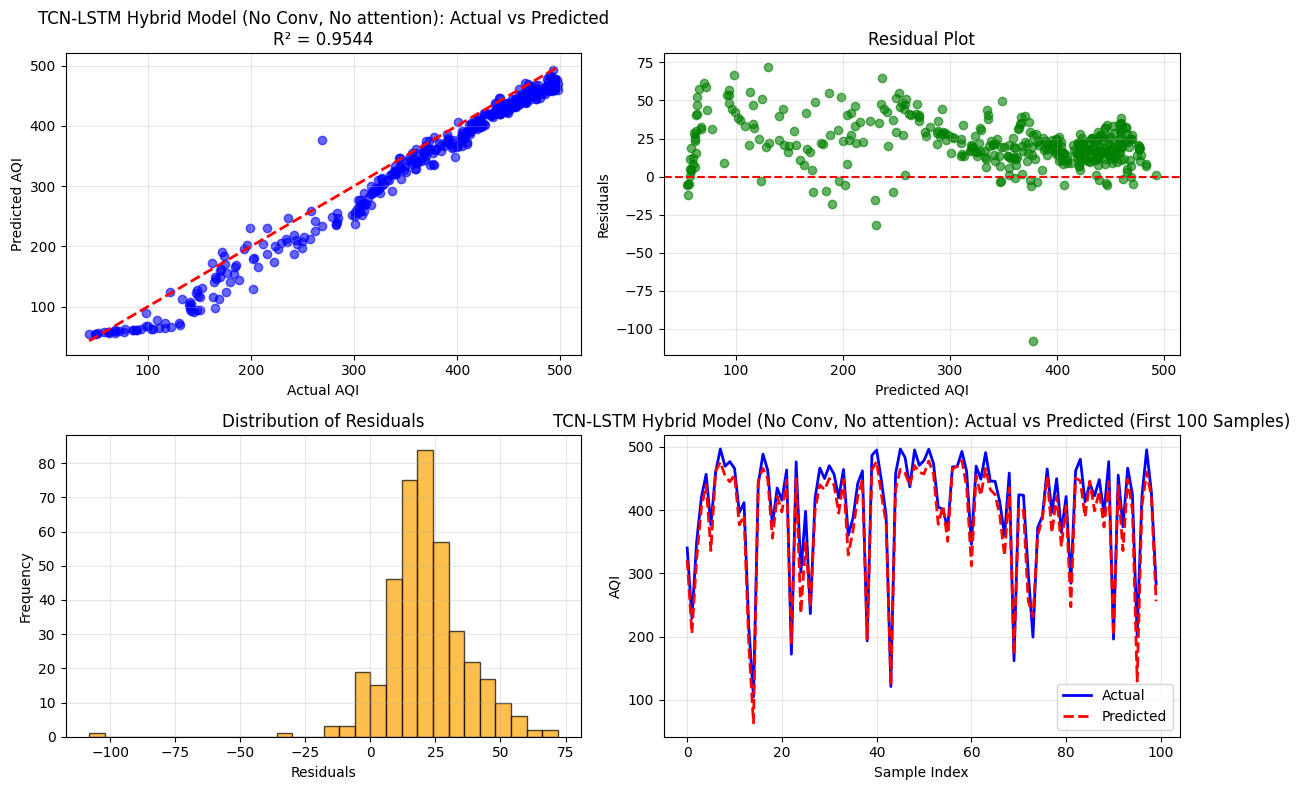

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Evaluate metrics function
def evaluate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return r2, rmse, mae, mape

# Plot function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

# Store for final fold plots
final_preds, final_y_val, final_history = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_hybrid_model_no_conv(input_shape=(1, X.shape[2]))  # 1 timestep, 6 features
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

    preds = model.predict(X_val).flatten()

    r2, rmse, mae, mape = evaluate_metrics(y_val, preds)
    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    if fold == kf.get_n_splits() - 1:
        final_preds = preds
        final_y_val = y_val
        final_history = history

# Final Averaged Metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(mape_scores):.2f}%")
print("=" * 40)

# Plot training vs validation loss for final fold
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot predictions for final fold
plot_model_results(final_y_val, final_preds, model_name="TCN-LSTM Hybrid Model (No Conv, No attention)")


## **TCN–LSTM–Conv1D Hybrid with Attention**


Fold 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Fold 1 R²: 0.9423, RMSE: 30.2986, MAE: 24.7468, MAPE: 11.39%

Fold 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Fold 2 R²: 0.9684, RMSE: 22.2188, MAE: 16.4680, MAPE: 7.77%

Fold 3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Fold 3 R²: 0.9398, RMSE: 30.5388, MAE: 14.5020, MAPE: 9.44%

Fold 4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Fold 4 R²: 0.9802, RMSE: 17.6742, MAE: 13.1494, MAPE: 4.81%

Fold 5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Fold 5 R²: 0.9695, RMSE: 21.7747, MAE: 16.8037, MAPE: 7.88%

Final Cross-Validated Metrics:
Mean R²:    0.9600
Mean RMSE:  24.5010
Mean MAE:   17.1340
Mean MAPE:  8.26%


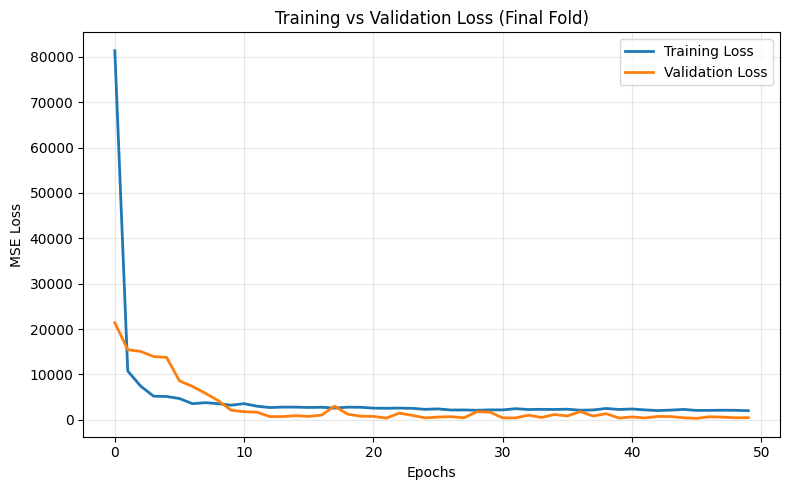

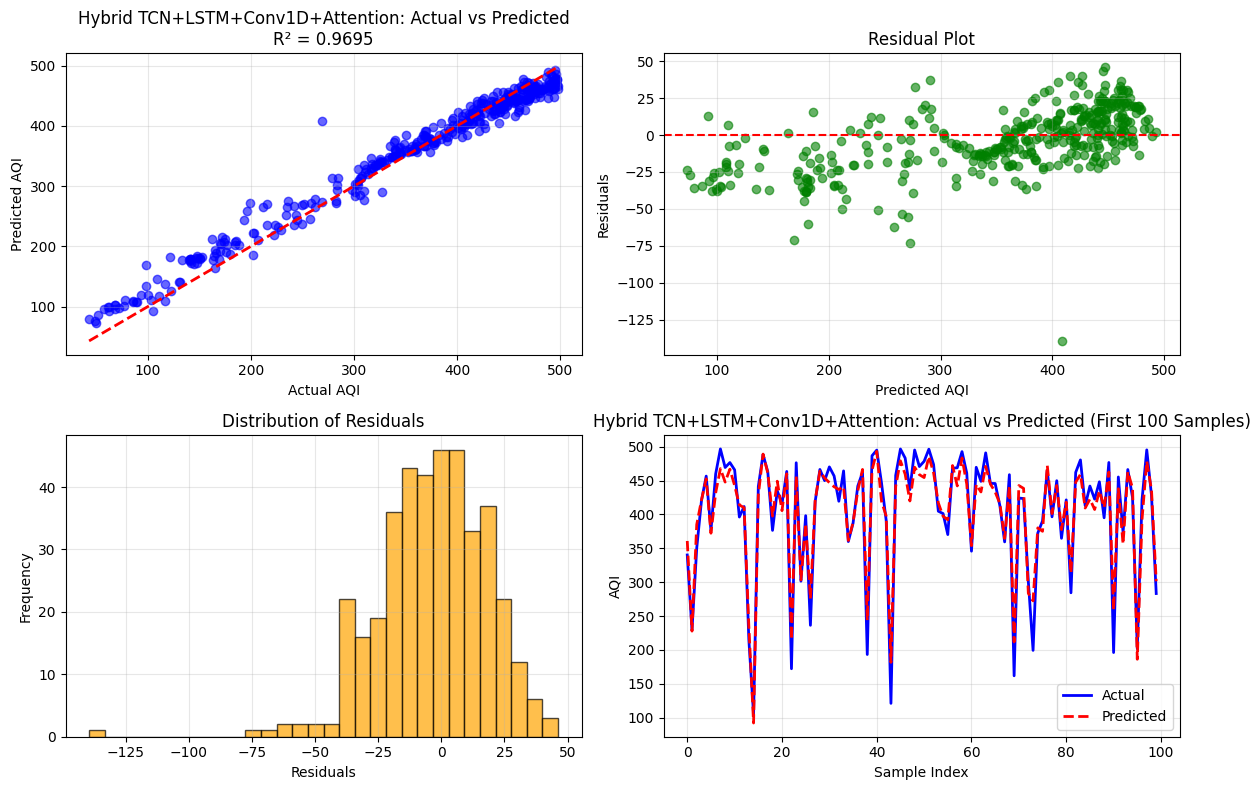

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import (Input, Dense, LSTM, Dropout, BatchNormalization,
                                     Concatenate, LeakyReLU, Multiply, Conv1D, GlobalMaxPooling1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# Load and preprocess data
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Attention block
def attention_block(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax')(inputs)
    return Multiply()([inputs, attention_weights])

# Plotting function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Hybrid model with TCN + LSTM + Conv1D + Attention
def create_hybrid_model_with_attention(input_shape, tcn_filters=64, lstm_units=128):
    inputs = Input(shape=input_shape)

    # TCN Branch
    tcn_branch = TCN(
        nb_filters=tcn_filters,
        kernel_size=2,
        dilations=[1, 2],
        activation='relu',
        dropout_rate=0.1,
        padding='causal',
        return_sequences=False,
        name='tcn_branch'
    )(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    # LSTM Branch
    lstm_branch = LSTM(lstm_units, activation='relu', return_sequences=False, name='lstm_branch')(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    # Conv1D Branch
    conv_branch = Conv1D(filters=32, kernel_size=1, activation='relu', name='conv1')(inputs)
    conv_branch = GlobalMaxPooling1D()(conv_branch)
    conv_branch = BatchNormalization()(conv_branch)
    conv_branch = Dropout(0.1)(conv_branch)

    # Combine all three
    combined = Concatenate()([tcn_branch, lstm_branch, conv_branch])

    # Apply attention
    attended = attention_block(combined)

    x = Dense(64)(attended)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32)(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

# For final fold plotting
final_history, final_y_val, final_preds = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_hybrid_model_with_attention(input_shape=(1, 6))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    print(f"Fold {fold + 1} R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    # Save last fold info
    if fold == kf.get_n_splits() - 1:
        final_history = history
        final_y_val = y_val
        final_preds = preds

# Final average metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot prediction diagnostics
plot_model_results(final_y_val, final_preds, model_name="Hybrid TCN+LSTM+Conv1D+Attention")


## **TCN–LSTM Hybrid with Attention & L2 Regularization (No Conv1D)**


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
R²: 0.9698, RMSE: 21.9121, MAE: 18.2984, MAPE: 7.70%

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
R²: 0.9533, RMSE: 27.0093, MAE: 22.9620, MAPE: 9.26%

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
R²: 0.9478, RMSE: 28.4332, MAE: 16.7104, MAPE: 8.08%

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
R²: 0.9580, RMSE: 25.7398, MAE: 19.2152, MAPE: 7.77%

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
R²: 0.9752, RMSE: 19.6432, MAE: 14.4854, MAPE: 5.13%

Final Cross-Validated Metrics:
Mean R²:    0.9608
Mean RMSE:  24.5475
Mean MAE:   18.3343
Mean MAPE:  7.59%


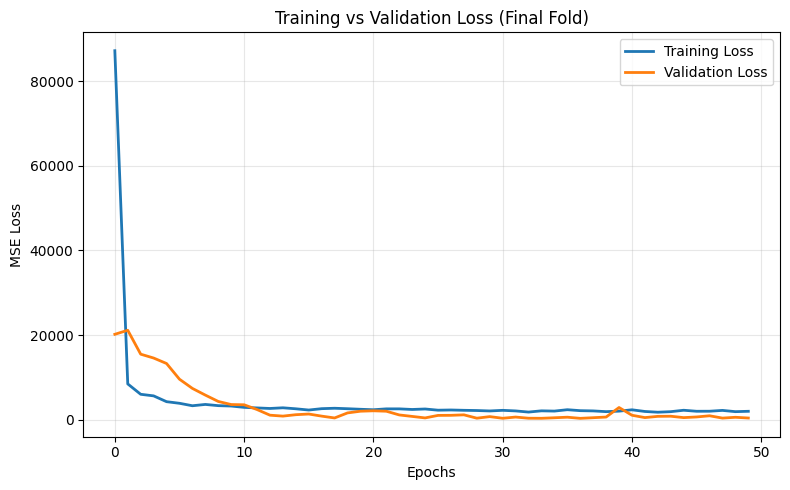

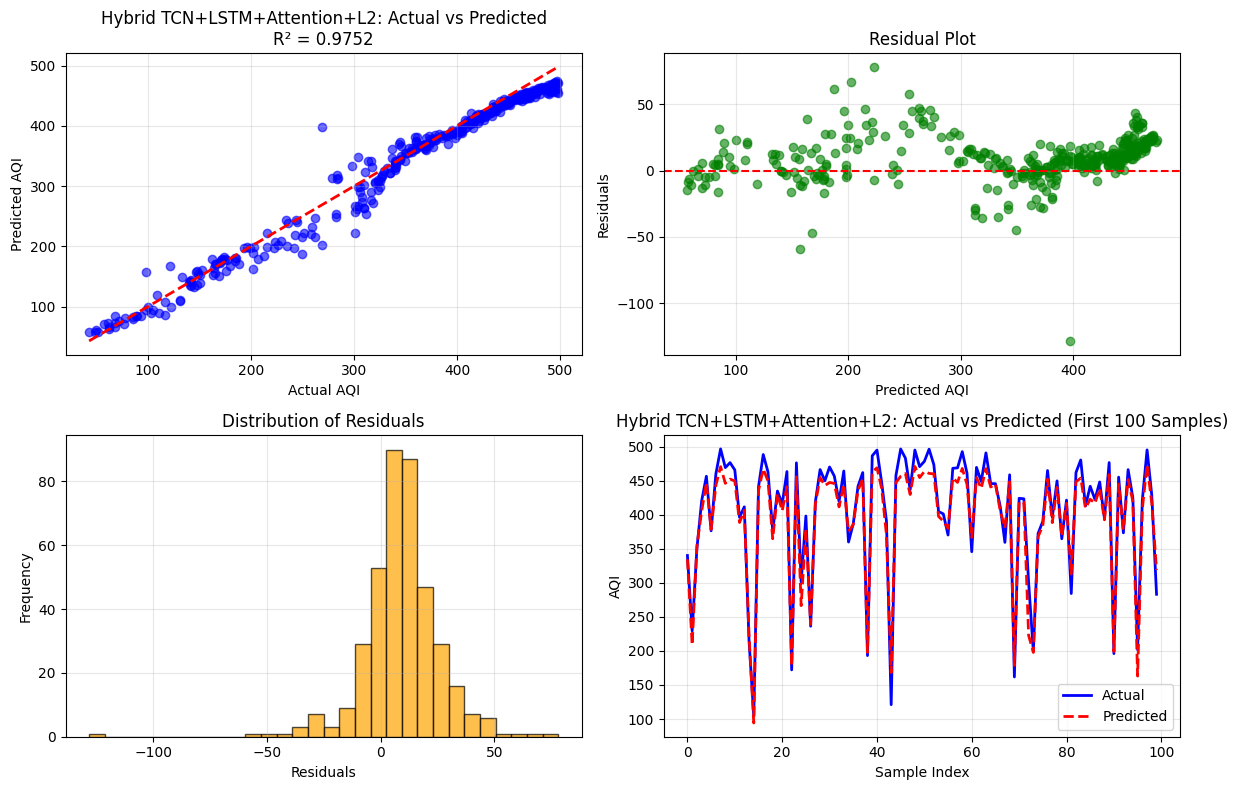

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Concatenate, LeakyReLU, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tcn import TCN

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

X = df[features].values
y = df[target].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time steps=1, features)

# Attention block
def attention_block(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax')(inputs)
    return Multiply()([inputs, attention_weights])

# Plotting function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Hybrid TCN+LSTM with Attention + L2
def create_hybrid_model_no_conv_with_attention_l2(input_shape, tcn_filters=64, lstm_units=128, l2_lambda=0.001):
    inputs = Input(shape=input_shape)

    # TCN Branch
    tcn_branch = TCN(
        nb_filters=tcn_filters,
        kernel_size=2,
        dilations=[1, 2],
        activation='relu',
        dropout_rate=0.1,
        padding='causal',
        return_sequences=False,
        name='tcn_branch'
    )(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    # LSTM Branch
    lstm_branch = LSTM(
        lstm_units,
        activation='relu',
        return_sequences=False,
        kernel_regularizer=l2(l2_lambda),
        name='lstm_branch'
    )(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    # Combine
    combined = Concatenate()([tcn_branch, lstm_branch])

    # Attention
    attended = attention_block(combined)

    # Dense Layers
    x = Dense(64, kernel_regularizer=l2(l2_lambda))(attended)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32, kernel_regularizer=l2(l2_lambda))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

final_history, final_y_val, final_preds = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_hybrid_model_no_conv_with_attention_l2(input_shape=(1, 6))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    # Save last fold
    if fold == kf.get_n_splits() - 1:
        final_history = history
        final_y_val = y_val
        final_preds = preds

# Final metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Training vs Validation Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction diagnostics
plot_model_results(final_y_val, final_preds, model_name="Hybrid TCN+LSTM+Attention+L2")


## ***GRU–TCN Hybrid ***


Fold 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
R²: 0.9760, RMSE: 19.5228, MAE: 14.6343, MAPE: 5.86%

Fold 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
R²: 0.9710, RMSE: 21.2653, MAE: 16.6657, MAPE: 5.80%

Fold 3
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
R²: 0.9544, RMSE: 26.5770, MAE: 13.2718, MAPE: 5.37%

Fold 4
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
R²: 0.8275, RMSE: 52.1452, MAE: 46.7678, MAPE: 12.84%

Fold 5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
R²: 0.7052, RMSE: 67.7153, MAE: 65.0926, MAPE: 21.12%

Final Cross-Validated Metrics:
Mean R²:    0.8868
Mean RMSE:  37.4451
Mean MAE:   31.2865
Mean MAPE:  10.20%


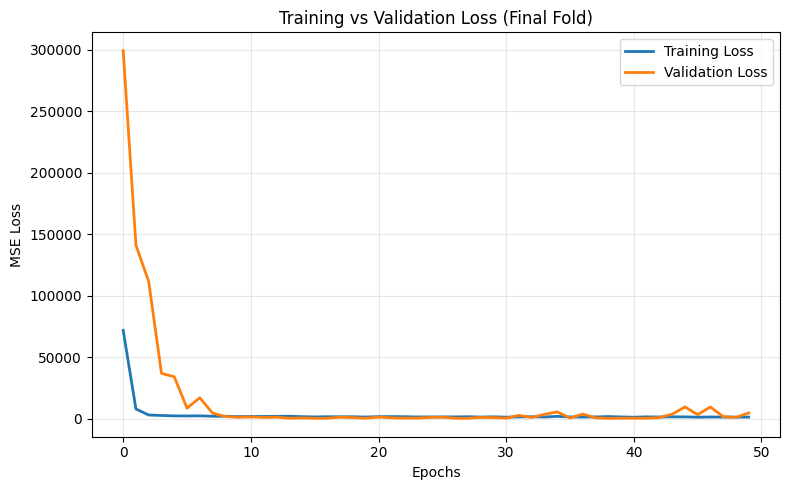

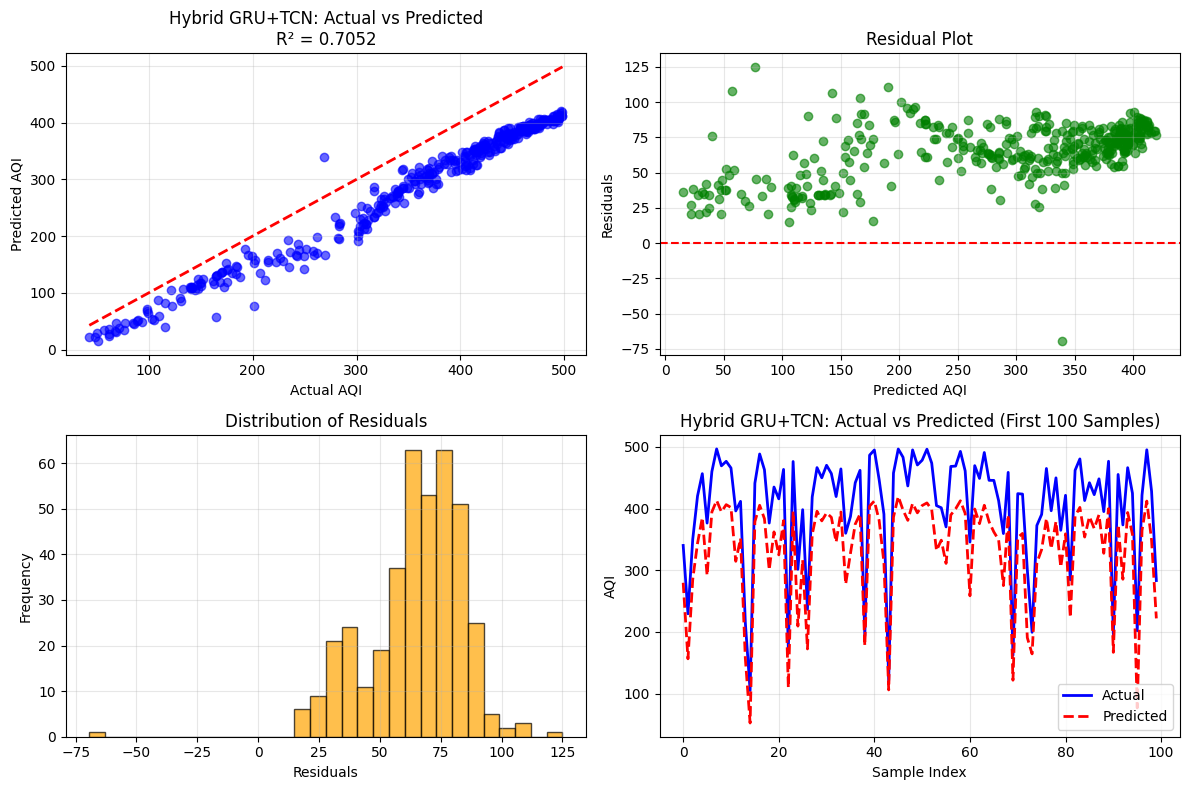

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GRU, Concatenate
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

X = df[features].values
y = df[target].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time steps, features)

# Define model
def create_gru_tcn_model(input_shape):
    inputs = Input(shape=input_shape)

    # GRU branch
    gru_branch = GRU(64, return_sequences=False)(inputs)
    gru_branch = BatchNormalization()(gru_branch)
    gru_branch = Dropout(0.3)(gru_branch)

    # TCN branch
    tcn_branch = TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16, 32])(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.3)(tcn_branch)

    # Combine both branches
    x = Concatenate()([gru_branch, tcn_branch])
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

# Plotting function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

final_history, final_y_val, final_preds = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_gru_tcn_model(input_shape=(1, 6))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    if fold == kf.get_n_splits() - 1:
        final_history = history
        final_y_val = y_val
        final_preds = preds

# Final averaged metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Training vs Validation Loss Plot (Final Fold)
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction diagnostics for final fold
plot_model_results(final_y_val, final_preds, model_name="Hybrid GRU+TCN")


## **GRU + TCN + Attention**


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
R²: 0.9625, RMSE: 24.4193, MAE: 18.7833, MAPE: 6.65%

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
R²: 0.8008, RMSE: 55.7562, MAE: 47.6205, MAPE: 13.71%

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
R²: 0.7769, RMSE: 58.7808, MAE: 49.5448, MAPE: 16.99%

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
R²: 0.9310, RMSE: 32.9878, MAE: 27.6680, MAPE: 8.97%

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
R²: 0.9639, RMSE: 23.6936, MAE: 15.4285, MAPE: 6.55%

Final Cross-Validated Metrics:
Mean R²:    0.8870
Mean RMSE:  39.1275
Mean MAE:   31.8090
Mean MAPE:  10.57%


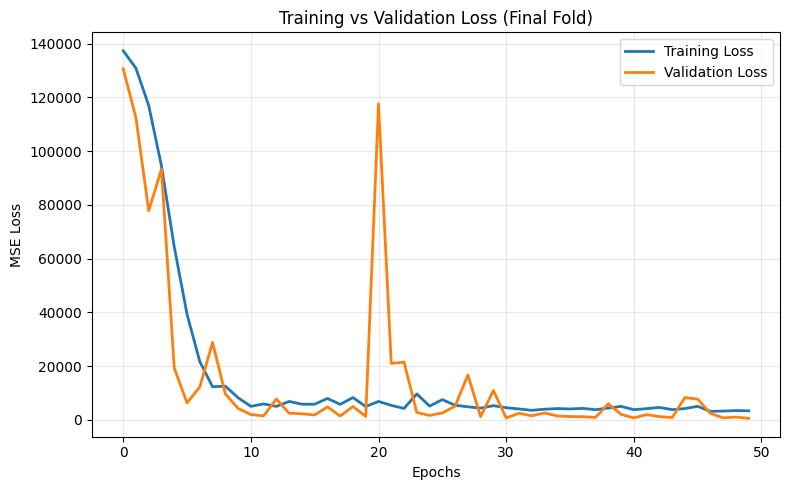

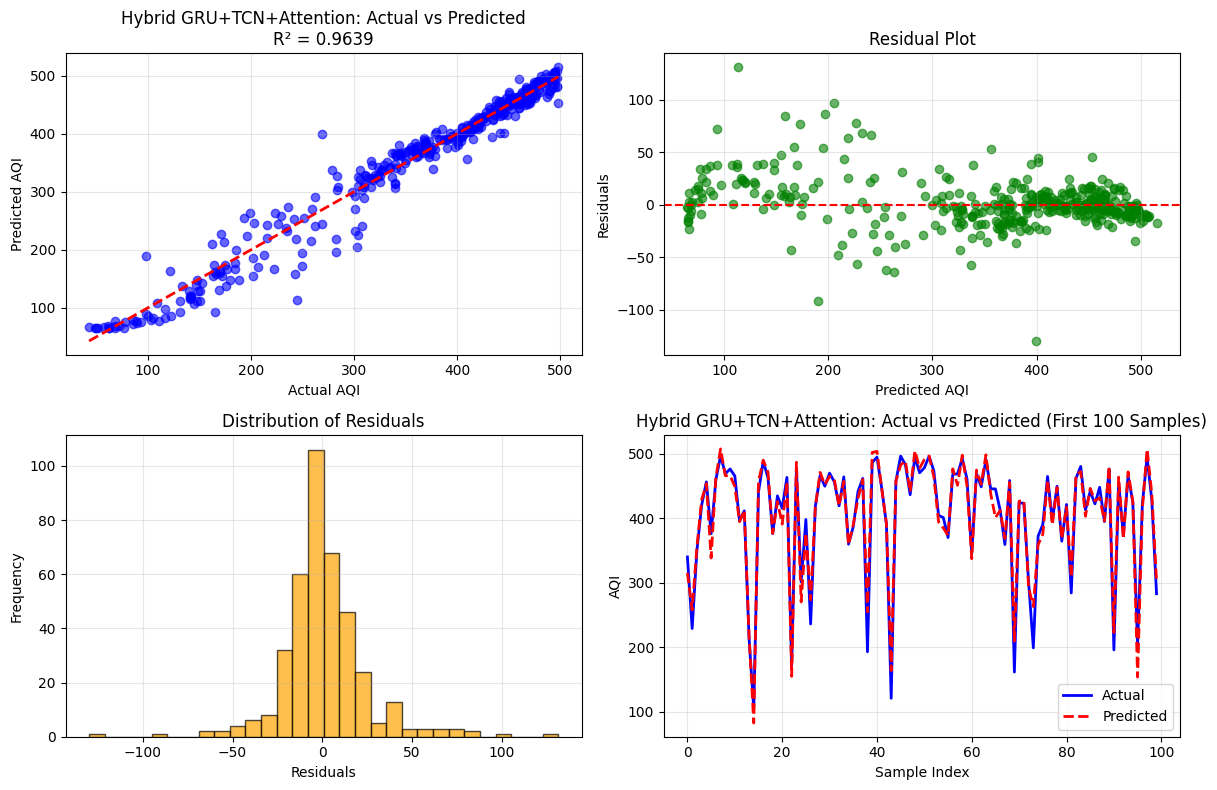

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Attention, Lambda
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

X = df[features].values
y = df[target].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Shape: (samples, time steps=1, features)

# Define hybrid model with GRU + TCN + Attention
def create_gru_tcn_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # GRU branch
    gru_out = GRU(64, return_sequences=True)(inputs)

    # TCN branch
    tcn_out = TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16, 32], return_sequences=True)(inputs)

    # Attention layer
    attn_out = Attention()([gru_out, tcn_out])
    attn_pooled = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attn_out)

    x = BatchNormalization()(attn_pooled)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

# Diagnostic plots
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

final_history, final_y_val, final_preds = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_gru_tcn_attention_model(input_shape=(1, 6))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-8))) * 100

    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    if fold == kf.get_n_splits() - 1:
        final_history = history
        final_y_val = y_val
        final_preds = preds

# Final averaged metrics
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Final fold loss curve
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final fold predictions diagnostic plot
plot_model_results(final_y_val, final_preds, model_name="Hybrid GRU+TCN+Attention")


## **TCN-LSTM + XGBoost Stacked Ensemble**


🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
📈 R²: 0.9962, RMSE: 7.7923, MAE: 3.6241, MAPE: 1.62%

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
📈 R²: 0.9880, RMSE: 13.6589, MAE: 6.9484, MAPE: 3.26%

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📈 R²: 0.9742, RMSE: 19.9888, MAE: 4.6067, MAPE: 2.63%

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📈 R²: 0.9983, RMSE: 5.2206, MAE: 2.6719, MAPE: 1.29%

🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
📈 R²: 0.9929, RMSE: 10.5104, MAE: 3.8923, MAPE: 1.83%

✅ Final Cross-Validated Ensemble Metrics:
Mean R²:    0.9899
Mean RMSE:  11.4342
Mean MAE:   4.3486
Mean MAPE:  2.13%


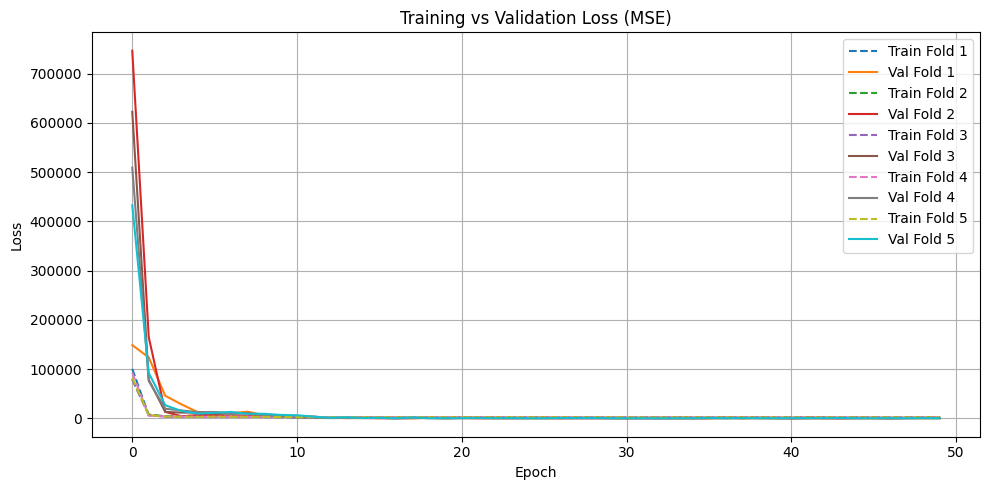

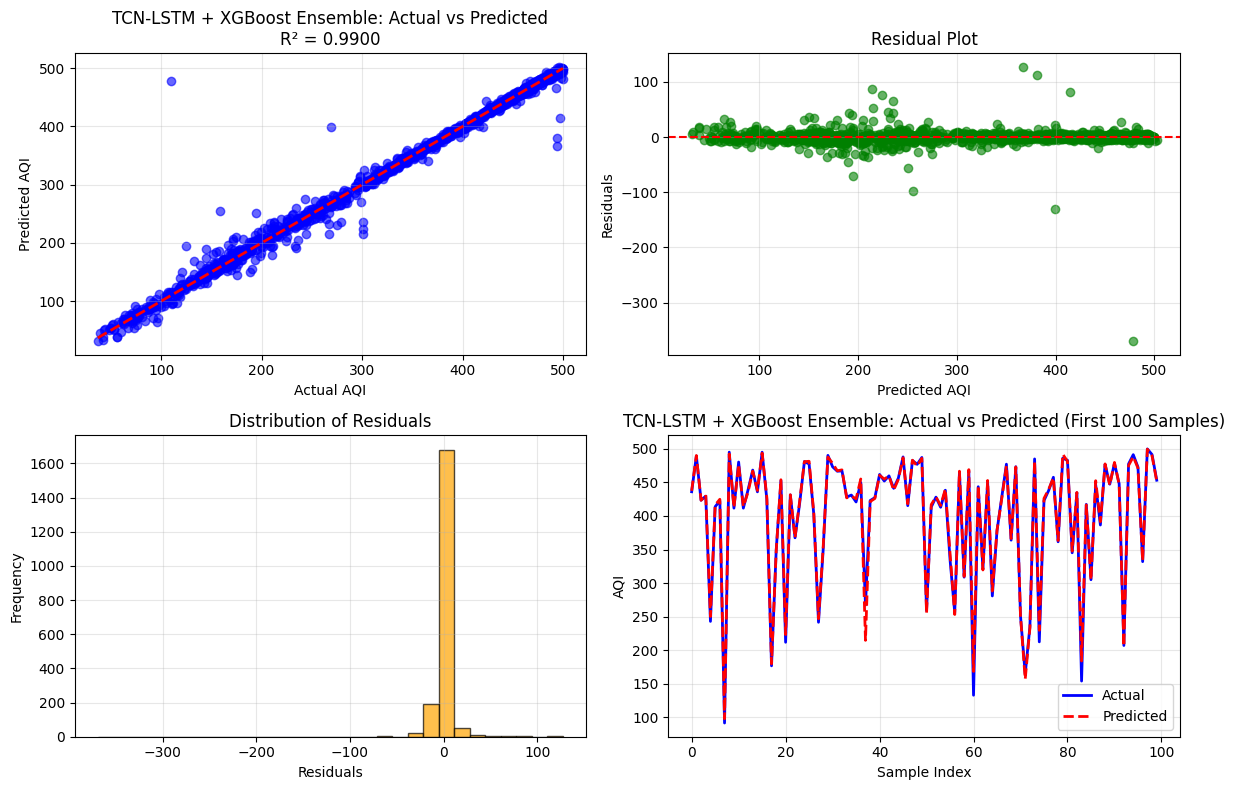

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values
X_tcn = X.reshape((X.shape[0], 1, X.shape[1]))

# Model builder
def create_hybrid_model_no_conv(input_shape, tcn_filters=64, lstm_units=128):
    inputs = Input(shape=input_shape)

    tcn_branch = TCN(nb_filters=tcn_filters, kernel_size=2, dilations=[1, 2], activation='relu',
                     dropout_rate=0.1, padding='causal', return_sequences=False)(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    lstm_branch = LSTM(lstm_units, activation='relu', return_sequences=False)(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    combined = Concatenate()([tcn_branch, lstm_branch])

    x = Dense(64)(combined)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

# Evaluation metrics
def evaluate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return r2, rmse, mae, mape

# Your existing plot function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    # Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    # Residuals
    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    # Distribution of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    # Time series (first 100)
    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# K-Fold training
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

train_losses = []
val_losses = []
all_actuals = []
all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train_tcn, X_val_tcn = X_tcn[train_idx], X_tcn[val_idx]
    X_train_flat, X_val_flat = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dl_model = create_hybrid_model_no_conv(input_shape=(1, X.shape[1]))
    dl_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = dl_model.fit(X_train_tcn, y_train, validation_data=(X_val_tcn, y_val),
                           epochs=50, batch_size=32, verbose=0)

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    dl_preds = dl_model.predict(X_val_tcn).flatten()

    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_flat, y_train)
    xgb_preds = xgb_model.predict(X_val_flat)

    stacked_input = np.column_stack((dl_preds, xgb_preds))
    meta_model = Ridge()
    meta_model.fit(stacked_input, y_val)

    final_preds = meta_model.predict(stacked_input)

    all_actuals.extend(y_val)
    all_predictions.extend(final_preds)

    r2, rmse, mae, mape = evaluate_metrics(y_val, final_preds)
    print(f"📈 R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

# Final metrics
print("\n✅ Final Cross-Validated Ensemble Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(mape_scores):.2f}%")
print("=" * 40)

# Training vs Validation Loss Plot
plt.figure(figsize=(10, 5))
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}', linestyle='--')
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final result plot
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)
plot_model_results(all_actuals, all_predictions, model_name="TCN-LSTM + XGBoost Ensemble")


## **Stacked TCN-LSTM + CatBoost (with Ridge meta-learner)**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values

# Reshape for TCN+LSTM input: (samples, timesteps, features)
X_tcn = X.reshape((X.shape[0], 1, X.shape[1]))

# Hybrid Model Definition
def create_hybrid_model_no_conv(input_shape, tcn_filters=64, lstm_units=128):
    inputs = Input(shape=input_shape)

    tcn_branch = TCN(nb_filters=tcn_filters, kernel_size=2, dilations=[1, 2], activation='relu',
                     dropout_rate=0.1, padding='causal', return_sequences=False)(inputs)
    tcn_branch = BatchNormalization()(tcn_branch)
    tcn_branch = Dropout(0.1)(tcn_branch)

    lstm_branch = LSTM(lstm_units, activation='relu', return_sequences=False)(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.1)(lstm_branch)

    combined = Concatenate()([tcn_branch, lstm_branch])

    x = Dense(64)(combined)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

# Evaluation metrics
def evaluate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return r2, rmse, mae, mape

# K-Fold stacking
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

print("\n📌 Model: Stacked TCN-LSTM + CatBoost (with Ridge meta-learner)")

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")

    # Split data for current fold
    X_train_tcn_fold, X_val_tcn_fold = X_tcn[train_idx], X_tcn[val_idx]
    X_train_flat, X_val_flat = X[train_idx], X[val_idx]  # for CatBoost
    y_train, y_val = y[train_idx], y[val_idx]

    # Deep Learning Model
    dl_model = create_hybrid_model_no_conv(input_shape=(1, X.shape[1]))
    dl_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    dl_model.fit(X_train_tcn_fold, y_train, validation_data=(X_val_tcn_fold, y_val),
                 epochs=50, batch_size=32, verbose=0)

    dl_preds = dl_model.predict(X_val_tcn_fold).flatten()

    # CatBoost Model
    cat_model = CatBoostRegressor(verbose=0, random_state=42)
    cat_model.fit(X_train_flat, y_train)
    cat_preds = cat_model.predict(X_val_flat)

    # Stack Predictions
    stacked_preds_input = np.column_stack((dl_preds, cat_preds))

    # Meta-Model (Ridge Regression)
    meta_model = Ridge()
    meta_model.fit(stacked_preds_input, y_val)
    final_preds = meta_model.predict(stacked_preds_input)

    # Evaluation
    r2, rmse, mae, mape = evaluate_metrics(y_val, final_preds)
    print(f"📈 R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

# Final averaged metrics
print("\n✅ Final Cross-Validated Ensemble Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(mape_scores):.2f}%")
print("=" * 40)



📌 Model: Stacked TCN-LSTM + CatBoost (with Ridge meta-learner)

🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
📈 R²: 0.9966, RMSE: 7.3812, MAE: 4.3976, MAPE: 1.93%

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
📈 R²: 0.9942, RMSE: 9.4911, MAE: 4.9593, MAPE: 2.13%

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
📈 R²: 0.9746, RMSE: 19.8246, MAE: 6.7198, MAPE: 3.32%

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
📈 R²: 0.9974, RMSE: 6.4036, MAE: 4.2462, MAPE: 1.71%

🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
📈 R²: 0.9938, RMSE: 9.7989, MAE: 5.0612, MAPE: 2.24%

✅ Final Cross-Validated Ensemble Metrics:
Mean R²:    0.9913
Mean RMSE:  10.5799
Mean MAE:   5.0768
Mean MAPE:  2.27%



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
📈 R²: 0.9965, RMSE: 7.4318, MAE: 4.4547, MAPE: 1.93%

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
📈 R²: 0.9943, RMSE: 9.4345, MAE: 5.1100, MAPE: 2.19%

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📈 R²: 0.9746, RMSE: 19.8426, MAE: 6.8005, MAPE: 3.25%

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
📈 R²: 0.9974, RMSE: 6.4042, MAE: 4.2386, MAPE: 1.71%

🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📈 R²: 0.9935, RMSE: 10.0224, MAE: 4.8875, MAPE: 2.26%

✅ Final Cross-Validated Ensemble Metrics:
Mean R²:    0.9913
Mean RMSE:  10.6035
Mean MAE:   5.0875
Mean MAPE:  2.27%


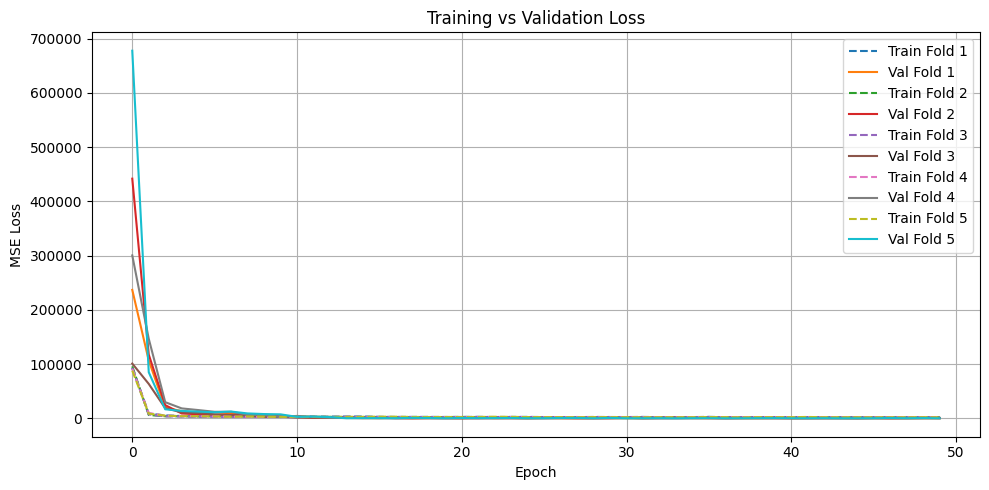

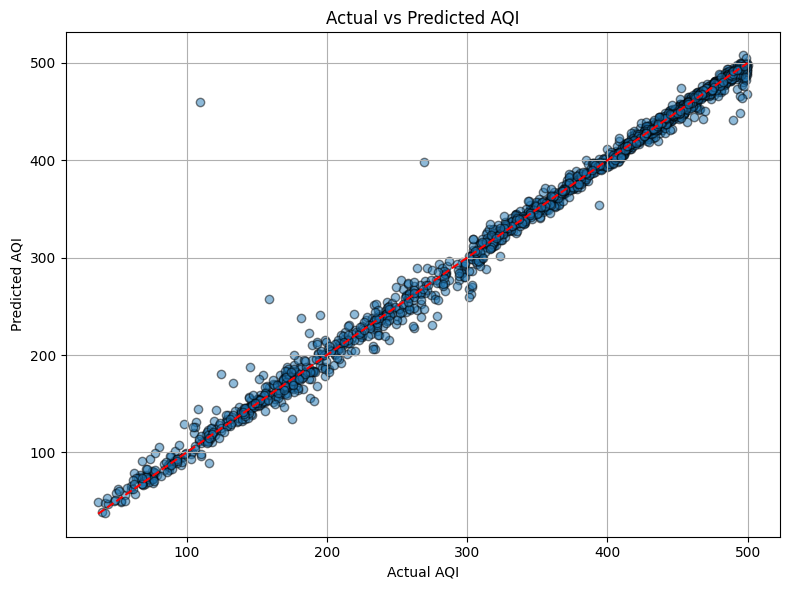

In [ ]:
import matplotlib.pyplot as plt

# Store training history and predictions
train_losses = []
val_losses = []
all_actuals = []
all_predictions = []

# REPLACE the existing loop with this modified one:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train_tcn_fold, X_val_tcn_fold = X_tcn[train_idx], X_tcn[val_idx]
    X_train_flat, X_val_flat = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dl_model = create_hybrid_model_no_conv(input_shape=(1, X.shape[1]))
    dl_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    history = dl_model.fit(X_train_tcn_fold, y_train, validation_data=(X_val_tcn_fold, y_val),
                           epochs=50, batch_size=32, verbose=0)

    # Save training/validation loss
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    dl_preds = dl_model.predict(X_val_tcn_fold).flatten()

    cat_model = CatBoostRegressor(verbose=0, random_state=42)
    cat_model.fit(X_train_flat, y_train)
    cat_preds = cat_model.predict(X_val_flat)

    stacked_preds_input = np.column_stack((dl_preds, cat_preds))
    meta_model = Ridge()
    meta_model.fit(stacked_preds_input, y_val)
    final_preds = meta_model.predict(stacked_preds_input)

    # Save actuals and predictions
    all_actuals.extend(y_val)
    all_predictions.extend(final_preds)

    r2, rmse, mae, mape = evaluate_metrics(y_val, final_preds)
    print(f"📈 R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

# Final ensemble metrics
print("\n✅ Final Cross-Validated Ensemble Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(mape_scores):.2f}%")
print("=" * 40)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}', linestyle='--')
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(all_actuals, all_predictions, alpha=0.5, edgecolors='k')
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--')
plt.title("Actual vs Predicted AQI")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.grid(True)
plt.tight_layout()
plt.show()


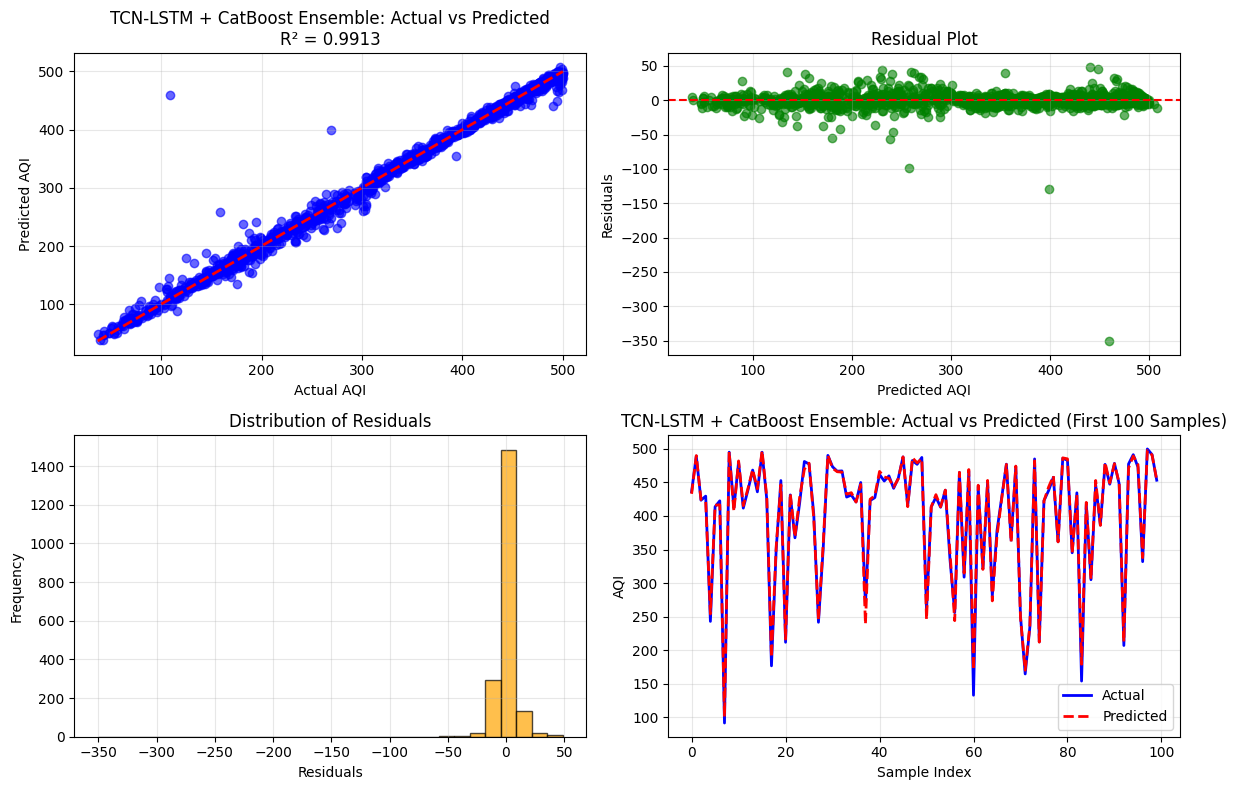

In [ ]:
# Convert to numpy arrays for compatibility
import numpy as np
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# Now plot using your custom function
plot_model_results(all_actuals, all_predictions, model_name="TCN-LSTM + CatBoost Ensemble")


In [ ]:
import pandas as pd

df=pd.read_csv('scaled_for_sequences.csv')
target_mean=df['AQI'].mean()
print("Mean of target: ", target_mean)

Mean of target:  351.3110096397768
